## Andrew Trieu - UWARG Computer Vision Bootcamp

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms 
# from tensorflow import keras
# from keras import datasets, layers, models

### Loading CIFAR10 Dataset and normalizing data 

In [2]:
# chaining multiple image transform operations together, 
# specifically converting the CIFAR10 dataset to meet required format for tensor-only transformations and normalizing each channel of the tensor
# tensor-only transformations can perform on batches of tensors, defined by (B, C, H, W)
    # B - number of images in the batch
    # C - number of channels (in this case: 3 channels - R, G, B)
    # H, W - image height and width
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
batch_size = 4  # number of samples to load per batch

# downloading PyTorch's CIFAR10 dataset from the internet and splitting into training and test set  
trainingset = torchvision.datasets.CIFAR10(root='./data', train = True, download = True, transform = transform) 
trainloader = torch.utils.data.DataLoader(trainingset, batch_size = batch_size, shuffle = True, num_workers = 2)  # shuffled on every epoch

testset = torchvision.datasets.CIFAR10(root = './data', train = False, download = True, transform = transform)
testloader = torch.utils.data.DataLoader(testset, batch_size = batch_size, shuffle = False, num_workers = 2)

classNames = ("airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck")


0.1%

100.0%


Extracting ./data\cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [14]:
testloader2 = torch.utils.data.DataLoader(testset, batch_size = 2, shuffle = False, num_workers = 2)

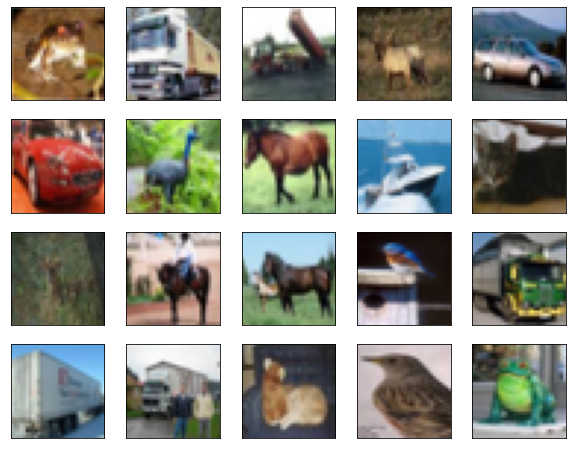

In [10]:
# classNames = ("airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck")

# plotting several images for data exploration

# plt.figure(figsize = (10, 10))
# for i in range(20):
#     plt.subplot(5, 5, i + 1)
#     plt.xticks([])
#     plt.yticks([])
#     plt.grid(visible = None)
#     plt.imshow(xTrain[i])
#     plt.xlabel(classNames[yTrain[i]], fontsize = 10, color = "white")
# plt.show()

### Terminology for the Convolutional Neural Network (CNN)

#### <u>Description</u>
Convolutional Neural Networks are neural networks specialized for image classifcation and computer vision tasks. They used supervised learning (labelled outputs). Typical architecture involves feature extraction layers, involving convolution and pooling, followed by an artificial neural network/fully connected neural network which will classify the image.

The "learning" of the deep learning model occurs in the fully connected layer. "Fully connected" describes the structure of the hidden layers - specifically how every neuron in a subsequent (hidden) layer is connected to every neuron in the previous layer. The relationship between the activation value of a neuron in a subsequent (hidden) layer and a neuron in its previous layer is the linear combination:

<ul>
    <li>activation/output = nonlinearity((weight_1 * input_1) + (weight_2 * input_2) + ... + (weight_n * input_n) + bias)  </li>
    , for n column vector in the previous layer 
</ul>

Initially, the weights and biases are assigned random values. The optimization of these values to reduce the error between the output and the labelled (true) value is akin to the neural network "learning". 
Weights are required because every neuron is looking for a different set of features, therefore inputs that are for a completely different feature should be weighed much lower than those that are being looked for. A bias is included to set intervals/limits on the activation value upon passing through the nonlinearity function. 

For every sample, upon reaching the predicted output, the loss is calculated. Loss is essentially how far away the predicted output is from the labelled output (true output), and is measured using a loss function. After every epoch (when each sample in the data set has passed through the neural network), gradient descent occurs. Gradient descent is an optimization algorithm to minimize the value of the loss function by iterating on the weight and bias values. Gradient descent uses backpropgation. Backpropagation is an algorithm to determine the gradient of the loss function. While the gradient provides the direction of greatest increase (gradient ascent), the negative of the gradient provides the direction of greatest decrease (gradient descent). In standard gradient descent, the gradient will be calculated for the output of every training sample. Once all training samples have been passed through the neural network, the average of all gradients calculated will be taken and used to modify the weight and bias values, scaled by a learning rate. The updated weight and bias values should result in a decreased loss value and push the function towards a minima value. However, the how much each weight and bias is modified by the gradient is relative to whether the output activation values need to increase or decrease (ex. if trying to guess a picture of a dog, but the activation values for cat and human are higher, then we need to increase the activation value of the dog neurons and decrease the activation valeus for cat and human), and the actual values in the previous layer. As we want to find the most efficient method of moving in the direction of gradient descent, usually the weights associated with large activation values will have the greatest modification as this will produce the greatest change. Determining how much each weight and bias should be modified by relative to their impact on the final output is known as backpropagation. 

<ul>
    <li> Convolution: Scanning through an input image (array of pixels) and calculating the dot product between it and a kernel/filter (a matrix of weights), with the addition of a bias, to create a feature map containing the weighted activation values of the input. Essentially determining what features are present.</li></br>
    <li> Pooling: summarizes (specifically down samples) the feature map - reduce dimensionality (reduce total computations), improve linear translational invariance to ensure the model is not impacted by variations in the location of the object (specific position of a feature will be not be important (ex. eyes in top left vs. middle of picture), as long as the feature exists in the image).
        <ul>
        <li>generally use a 2x2 kernel to traverse the feature map and perform a pooling operation (such as max or average of the values in a patch) to summarize the features per area in the input.</li>
        <li>despite the reduction in resulting array size, the most important feature information is retained and reduction in dimensionality prevents overfitting</li>
        <li><u>Stride:</u> number of units the kernel moves after each operation</li>
            <ul>
                <li>if stride = kernel size == 2, the output matrix is half the size of the input b/c every 2x2 patch is summarized to 1 cell in the pooled array</li>
            </ul>
        <li>Due to the pooling operations conducted, the activation values per patch of the feature map are summarized into one cell, therefore
        the important activation of a patch will show up in the pooled feature map, despite variances in the feature's location in the feature map</li>
        </ul>
    </li><br/>
    <li>Weight: Value associated with each input activation value. It scales the activation values and is one of the two parameters whose value is optimized in gradient descent using backpropagation.</li><br/>
    <li>Bias: Value added to the linear combination of all weights and input values. Plays a key role in affecting the value determined by the nonlinear function by determining a cutoff for transitional values of the nonlinearity. 
    Example for ReLU = max(0, input). By setting bias = -10, if the value of the linear combination is less than or equal to 10, ReLU = 0.   
    </li><br/>
    <li>
    Nonlinearity: Nonlinear function used to transform the weighted input values of a layer into an output activation value, which allows the model to have non-linear behaviour (which describes most deep learning problem spaces). If linear functions were used, the neural net would essentially be as powerful as a single neuron.
        <ul>
        Popular nonlinearity functions:
            <ol>
                <li>ReLU (Rectified Linear Unit) - max(0, input). Therefore, ReLU(input) = 0 for input <= 0, linear function for input > 0
                <ul>
                    <li>problem with ReLU - "dead neuron problem" derivative of ReLU = 0 when input is negative
                    therefore if too many features are negative, then ReLU(input) = 0 and gradient = 0 </li>
                </ul></li>
                <li>hyperbolic tan tanh(s) - unused because of vanishing gradient problem --> as value of s approaches infinity, 
                derivative (and thus gradient) of tanh approaches 0, therefore with more layers, the gradient --> 0. 
                With gradient --> 0, training times increase exponentially and gradient descent becomes very inefficient</li>
                <li>sigmoid function - values between 0 and 1 (therefore used for binary classification ex. logistic regression)
                like tanh, runs in to vanishing gradient problem as sigmoid function is parallel for large positive and negative inputs,
                therefore gradient --> 0 and neural network cannot learn </li>
            </ol>
        These nonlinearities are also popular due to the ease of finding their derivatives, making backpropagation calculations easier
        </ul>
    </li><br/>
    <li>Backpropagation: Determining the gradient of a loss function given weight and bias input parameters. This gradient will determine how much each weight and bias will be modified, and is largely focused on being efficient. Therefore each weight and bias value will be modified differently depending on how beneficial it is for it to increase or decrease, and by how much. </li><br/>
    <li>Loss function: Determines how far the predicted output is from the true output for a given set of weight and bias values. There are numerous loss functions used, but common loss functions include: 
<ul> 
        <li>Mean Square Error (MSE): for every trial, sum up the square of the difference between the predicted and true outputs for every output activation, then take the average of all values</li>
        <li>Likelihood loss: Multiply all activation values together. For any given sample, if the expected output activation is 0, use 
        (1 - activation value) instead. </li>
        <li><strong>Cross entropy loss (log loss):</strong> Formula: -(y*log(p) + (1-y)*log(1-p))
                                           if actual output = 1, only first half is used ; if actual output is 0, only second half is used
                                           due to a log function being used, predictions that are very far away from the expected value generate a much larger loss value
        </li>
</ul>
</li>
<br/>
    <li>Optimization Algorithms for DL training: </li>
<ul>
        <li> Gradient Descent & Backpropagation: 
            <ul>
                <li><u>Backpropagation</u> is an algorithm used to determine the gradient of a loss function. The gradient is comprised of the partial derivatives of the loss function with respect to each parameter of every neuron for every layer of the artificial neural network. Backpropagation applies the chain rule for partial derivatives to determine the rate of change of these parameters (weight, bias, activation) with respect to the loss function. The hierarchy of relationships between parameters and loss function can be mapped by a tree, where derivatives must be taken at each level of the tree and multiplied to result in the derivative of the loss function with respect to a parameter. The derivative of the nonlinearity comes into play here.</li>
                <li><u>Gradient Descent</u> is an iterative optimization algorithm that pushes a function towards its minima in discrete steps, always taking the path with the steepest slope downwards - using the negative of the gradient calculated in backpropagation. The gradient is a vector that points in the direction of greatest increase. For every step, the values of the parameters of the NN (weight, bias, activation values) are modified and should result in a reduction of the value of the loss fuction. The amount they are updated is limited by the learning rate. The learning rate scales the gradient down to prevent overshooting of a local minima. Some common problems associated with GD: vanishing gradient, saddle points (both cases, derivative approaches or is equal to 0, but not at a minima)  </li>
            </ul>
        </li>
        <li>Stochastic Gradient Descent (SGD): Determining the gradient for every sample in a dataset is very computationally expensive and slow. A much faster approach is to shuffle the dataset and divide it into mini-batches, then determine the gradient for the mini-batch. The weight and bias values will be updated based on the gradient of each mini-batch. This results in less accurate gradient descent steps (not the optimal direction) but the overall run time will decrease dramatically. Therefore, the overall gradient descent will consist of rapid but less accurate steps to reach the minima, instead of very slow/expensive but optimal steps. </li>
        <li> SGD w/ <u>Momentum</u>: Steps in standard SGD (updates to parameter values) only take into account the learning rate and current gradient value, but do not factor in previous gradient values. This leads to two common problems that can arise from standard SGD:   
        <ol>
            <li>Saddle point/plateau: if the optimization algorithm reaches a saddle point in the loss function, the gradient will be near zero and the parameters (weight, bias, activation value) will be barely updated. This leads to very slow/no learning of the model.  </li>
            <li>Gradient descent steps can be inefficient due to learning rate value being too small (steps are too small --> extra computations required) or too large (oscillating around minima)</li>
        </ol>
        Including momentum, or an exponentially weighted moving average, with the stochastic gradient descent can help tackle these issues. Exponentially weighted moving average (EWMA) factors in the values of past terms in a sequence to affect the current value, with the weight of past values being determined by the momentum constant (value between 0 and 1). Lower constant values will cause the importance of past values to drop off faster. A momentum constant of 0.9 is commonly used. For a coefficient of 0.9, current term weight is 100%, second term weight is 90% (1 * 0.9), third term weight is 81% (0.9 * 0.9) etc... 
        <ol>
            <li>When encountering a saddle point, the EWMA will cause the resulting gradient to be a substantial amount, larger than zero, pushing the algorithm towards the optima much faster compared to standard SGD. </li>
            <li>The equation for weight update using momentum/EWMA: </br>
            <center>weight_update = LR * summation from t=0 to n[constant*gradient(t)]</center>
            , where LR = learning rate, n = current gradient step, constant = momentum constant, gradient(t) = gradient value at that step
                <ul>
                    <li>from the equation: if the gradients are all the same sign, the weights/parameters will be updated by larger amounts (thus larger steps will be taken) even if a small learning rate is used, which accelerates gradient descent </li>
                    <li>if the gradients are different signs, this means the algorithm is oscillating about the function. weight update values will decrease, minimizing the effects of the oscillations.</li>
                </ul>
            </li>
        </ol>
        </li>
</ul></br>

<li> Learning rate/step size: The learning rate scales the gradient to limit the amount by which each weight is modified during backpropagation to prevent overshooting of the minimum value of the loss function. Too small of a learning rate would allow the function to overshoot the minimum value, however too small of a learning rate would mean many more computations need to be performed to reach the minimum value.</li>
</ul>

### <u>Architecture of CNN</u>

Feature Extraction Layers:
<ol>
    <li>Convolution Layers</li>
    <li>Nonlinearity</li>
    <li>Pooling Layers</li>
</ol>
> Can be repeated several times.

Artificial Neural Network:
<ol>
    <li>Input --> flattened to become 1D column vector</li>
    <li>Fully Connected Neural Network</li>
        <ul>
            <li>Each neuron is initialized with "random" weights and biases which will be optimized via backpropagation and gradient descent </li>
            <li>ReLU activation function prepares the activation values from a previous layer for the subsequent layer</li>
        </ul>
    <li>Output --> classification of the image</li>
</ol>
> Learning of the neural network via gradient descent and backpropagation occur here.

### <u>Backpropagation</u>

<ul>
    <li>Cross-Entropy/Logarithmic Loss Function: Multiplies all activation values </li>

</ul>

In [22]:
# defining the CNN

class Net(nn.Module):
    """
    Defines the layers of the Convolutional Neural Network (CNN) and forward propagation of the model 

    Attributes
    ----------
    firConvLayer: torch.nn.Conv2d<in_channels: int, out_channels: int, kernel_size: int>
        First convolution layer. 5x5 kernel performing dot product along input image. Takes in 3 input channels (R, G, B layers for every image) 
        and outputs 6 channels.
    pool: torch.nn.MaxPool2d<kernel_size: int, stride: int>
        Pooling layer outputting the maximum value per 2x2 patch of the input  
    sndConvLayer: torch.nn.Conv2d<in_channels: int, out_channels: int, kernel_size: int>
        Second convolution layer. Same function as first convolutional layer except input and output channels have been modified
    firFullyConnected: torch.nn.Linear<in_features: int, out_features: int>
        First fully connected layer in the ANN. Takes flattened ouput tensor of classifcation layers as input.
    sndFullyConnected: torch.nn.Linear<in_features: int, out_features: int>
        Second fully connected layer in the ANN. Takes output of first fully connected layer as input.
    output: torch.nn.Linear<in_features: int, out_features: int>
        Final fully connected layer leading to a classification prediction. Takes output of second fully connected layer as input.

    Methods
    -------
    __init__()
        Defines architecture of each layer of the CNN and defines inheritance from nn.module superclass
    forward(x: torch.Tensor)
        Defines forward propagation sequence - convolution layers and fully connected layers
    """
    def __init__(self):
        super().__init__()  # access to methods of nn.module (superclass we are inheriting from)
        
        
        # nn.Conv2d description
        # first 2d convolutional layer with 3 input channels (R, G, B), 6 output channels, and kernel (filter) size 5x5
        # weight and bias values for the convolution layers are initially set to values depending on # of input & output channels + kernel size
        self.firConvLayer = nn.Conv2d(3, 6, 5)  
        
        # nn.MaxPool2d is the pooling layer that determines max. value along the feature map in 2x2 kernels, default stride = kernel size == 2
        self.pool = nn.MaxPool2d(2, 2)
        self.sndConvLayer = nn.Conv2d(6, 16, 5)

        # nn.Linear(num_input_channels, num_output_channels, bias = True) 
        # Artificial Neural Network/Fully Connected Neural Networks
        # nn.Linear performs a linear transformation equation Ax = b to calculate A (matrix of weights) associated with each neuron, 
        # along with a bias. The weights and bias are set to an initial value and are iterated upon in backpropagation  
        self.firFullyConnected = nn.Linear(16 * 5 * 5, 120)  
        self.sndFullyConnected = nn.Linear(120, 84)
        self.output = nn.Linear(84, 10)
    
    def forward(self, x):
        # Forward propagation
        # General outline: input --> convolution layer --> nonlinearity --> pooling layer ... --> fully connected layer

        # for nn.Conv2d and nn.Linear functions, their parameter variables only define attributes of the convolution/linear operations
        # need to apply these functions to a tensor - this is the variable "x"

        # Classification layers
        x = self.pool(F.relu(self.firConvLayer(x)))
        x = self.pool(F.relu(self.sndConvLayer(x)))
        x = torch.flatten(x, 1)  # flatten the output of convolution layer into column vector to use as input for ANN

        # Artificial neural network/fully connected layers
        x = F.relu(self.firFullyConnected(x))
        x = F.relu(self.sndFullyConnected(x))
        x = self.output(x)  # final classification uses Linear activation - 10 channels which each represent an output classification
        return x

net = Net()


In [23]:
# defining the loss function and gradient descent

criterion = nn.CrossEntropyLoss() # Cross Entropy/logarithmic loss function used
gradDesc = optim.SGD(net.parameters(), lr = 0.001, momentum = 0.9)  # stochastic gradient descent w/ momentum

In [25]:
# training the network

# include plot of loss per epoch for training and validation datasets - matplotlib
cumulativeLoss = []

for epoch in range(5):
    running_loss = 0.0

    # retrieving training data set - each batch has 4 samples, total of 12500 batches (50,000 images for training/4 images per batch)
    for batch_index, samples in enumerate(trainloader):
        images, labels = samples  # data is a list of [inputs, labels]

        gradDesc.zero_grad()  # clear existing gradients (zero the gradient buffer) to prevent the accumulation of previous gradient values

        # forward propagation --> back propagation --> gradient descent to optimize (find a minima of) loss function
        outputs = net(images)
        loss = criterion(outputs, labels)  # need to define (input, target) for nn.CrossEntropyLoss. diff between model prediction and true label
        loss.backward()  # backpropagation --> calculating the gradient of the loss function
        gradDesc.step()  # updates to weight and bias values
        
        running_loss += loss.item()
        if batch_index == 12499:
            avgLoss = running_loss / 12500
            cumulativeLoss.append([epoch + 1, avgLoss])
            print(avgLoss)
        # if batch_index % 2000 == 1999:  # prints every 1999 + 1 batches, where each batch = 4 samples
        #     avgLoss = running_loss / 2000
        #     cumulativeLoss.append([(epoch + 1, batch_index + 1), avgLoss])
        #     # plot loss per batch per epoch here
        #     print(f'[{epoch + 1}, {batch_index + 1:5d}] loss: {avgLoss:.3f}')  # average loss across each batch per epoch
        #     running_loss = 0.0

print("Finished Training")

1.1837979445540905
1.0960267406876385
1.0241578559269011
0.9684200661168806
0.9212810537039582
Finished Training


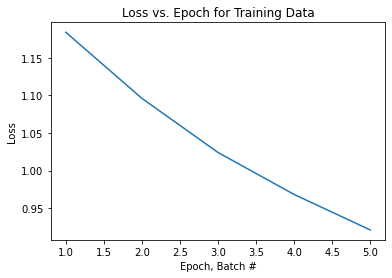

In [26]:
# plot stuff here
x = []
y = []

for index, val in enumerate(cumulativeLoss):
    x.append(cumulativeLoss[index][0])
    y.append(cumulativeLoss[index][1])

plt.title("Loss vs. Epoch for Training Data")
plt.xlabel("Epoch, Batch #")
plt.ylabel("Loss")
plt.plot(x, y)
plt.show()

In [27]:
PATH =  './cifar_net.pth'
torch.save(net.state_dict(), PATH)  # state_dict() contains the parameters and buffers of the module

In [ ]:
# loading the saved model

net = Net()
net.load_state_dict(torch.load(PATH))

In [15]:
for data in testloader2:
    images, labels = data
    print(labels)

tensor([3, 8])
tensor([8, 0])
tensor([6, 6])
tensor([1, 6])
tensor([3, 1])
tensor([0, 9])
tensor([5, 7])
tensor([9, 8])
tensor([5, 7])
tensor([8, 6])
tensor([7, 0])
tensor([4, 9])
tensor([5, 2])
tensor([4, 0])
tensor([9, 6])
tensor([6, 5])
tensor([4, 5])
tensor([9, 2])
tensor([4, 1])
tensor([9, 5])
tensor([4, 6])
tensor([5, 6])
tensor([0, 9])
tensor([3, 9])
tensor([7, 6])
tensor([9, 8])
tensor([0, 3])
tensor([8, 8])
tensor([7, 7])
tensor([4, 6])
tensor([7, 3])
tensor([6, 3])
tensor([6, 2])
tensor([1, 2])
tensor([3, 7])
tensor([2, 6])
tensor([8, 8])
tensor([0, 2])
tensor([9, 3])
tensor([3, 8])
tensor([8, 1])
tensor([1, 7])
tensor([2, 5])
tensor([2, 7])
tensor([8, 9])
tensor([0, 3])
tensor([8, 6])
tensor([4, 6])
tensor([6, 0])
tensor([0, 7])
tensor([4, 5])
tensor([6, 3])
tensor([1, 1])
tensor([3, 6])
tensor([8, 7])
tensor([4, 0])
tensor([6, 2])
tensor([1, 3])
tensor([0, 4])
tensor([2, 7])
tensor([8, 3])
tensor([1, 2])
tensor([8, 0])
tensor([8, 3])
tensor([5, 2])
tensor([4, 1])
tensor([8,

In [28]:
# testing the model on the validation dataset
correct = 0
total = 0

with torch.no_grad():
    for data in testloader: 
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)  # returns a tuple of max value (redundant) and max index (used to check the classification)
        total += labels.size(0)  # increments by 1
        correct += (predicted == labels).sum().item()  # batches of 4 images, .sum() adds all 1 (True) in a batch, .item() converts tensor to int 
        # print(predicted , labels)

#print(f"Accuracy of the network using 10,000 test images: {(correct // total) * 100}%")
print(f"Accuracy of the network using 10,000 test images: {100 * correct // total}%")

Accuracy of the network using 10,000 test images: 62%
